In [1]:
import pandas as pd
import numpy as np
from modeling import cleaned_fr
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

ML Lib:

In [2]:
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# _Robust Scaled Model no Systolic__

# Experiment 1

Fitting some basic models and assessing their performance without any parameter fine-tunning.

In [3]:
# Models in experiment 1
models = {
            'BernoulliNB' : BernoulliNB(),
            'GaussianNB' : GaussianNB(),
            'DTr' : DecisionTreeClassifier(),
            'ExTrs': ExtraTreesClassifier(),
            'KNeigh' : KNeighborsClassifier(),
            'svc': SVC(probability=True),
            'xgb' : XGBClassifier(),
            'logistic' : LogisticRegression(),
            'MLP' : MLPClassifier()
        }

In [4]:
# Importing cleaned frame
df = cleaned_fr(avoid_systolic=True)

# Separating
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Select binary columns to avoid scaling below
binary_cols = X.select_dtypes('uint8').columns

# Remaining columns
non_binary_cols = [col for col in X.columns if col not in binary_cols]

# Times to repeat Kfold instance
rKF = RepeatedKFold(n_repeats=34, n_splits=3, random_state=23)

In [5]:
# Transformer that scales the non-binary columns and does nothing to the binary columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), non_binary_cols),
        ('bin', FunctionTransformer(None, validate=False), binary_cols) # does nothing
    ])

_folds, _names, _accuracy, _precision, _recall, _f1, _auc, _set_type = [], [], [], [], [], [], [], []

for MODEL_NAME, ML_MODEL in models.items():
    for fold_id, (train_index, test_index) in enumerate(rKF.split(X)):
        
        # Train test split
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index] 

        # Pipeline for training
        _local_pipe = Pipeline([
                                ('preprocessor', preprocessor),
                                (MODEL_NAME, ML_MODEL)
                            ])

        # Fitting
        _local_pipe.fit(X_train, y_train)

        # Test the results in training and test to check for overfitting
        lab = {'train' : (X_train, y_train), 'test': (X_test, y_test)}

        for lab_type, (X1,Y1) in lab.items():

            # Keeping len
            _folds.append(fold_id)
            _names.append(MODEL_NAME)
            _set_type.append( lab_type )

            # Predictions
            y_pred = _local_pipe.predict(X1)

            # Proba for AUC
            y_proba = _local_pipe.predict_proba(X1)[:, 1]  # Probabilities for the positive class
            _auc.append( roc_auc_score(Y1, y_proba) )
            
            # Metrics
            _accuracy.append( accuracy_score(Y1, y_pred) )
            _precision.append( precision_score(Y1, y_pred) )
            _recall.append( recall_score(Y1, y_pred) ) #<-- intended
            _f1.append( f1_score(Y1, y_pred) )

In [6]:
# Saving in DataFrame
result_df = pd.DataFrame( {'fold_id':_folds, 'model_name':_names, 'set': _set_type, 'accuracy':_accuracy, 'precision':_precision, 'recall':_recall, 'f1':_f1, 'auc':_auc} )

In [7]:
# Quick  look to the average performance
result_df.groupby(by=['model_name','set']).agg({'mean'}).loc[:,'recall'].unstack().droplevel(0,axis=1).filter(['train','test']).sort_values(by=['test'], ascending=False)

set,train,test
model_name,,
svc,0.922556,0.921735
GaussianNB,0.919682,0.916567
MLP,0.920367,0.915557
xgb,0.924952,0.909378
KNeigh,0.913085,0.899896
logistic,0.902433,0.898346
BernoulliNB,0.896824,0.896627
ExTrs,0.920281,0.879645
DTr,0.920281,0.874272


In [8]:
# Quick  look to the average performance
result_df.groupby(by=['model_name','set']).agg({'std'}).loc[:,'recall'].unstack().droplevel(0,axis=1).filter(['train','test']).sort_values(by=['test'])

set,train,test
model_name,,
svc,0.017024,0.033867
BernoulliNB,0.018487,0.035979
MLP,0.017526,0.036209
xgb,0.017079,0.036583
logistic,0.018465,0.037243
GaussianNB,0.014940,0.040144
KNeigh,0.020188,0.043232
ExTrs,0.017235,0.054453
DTr,0.017235,0.057255


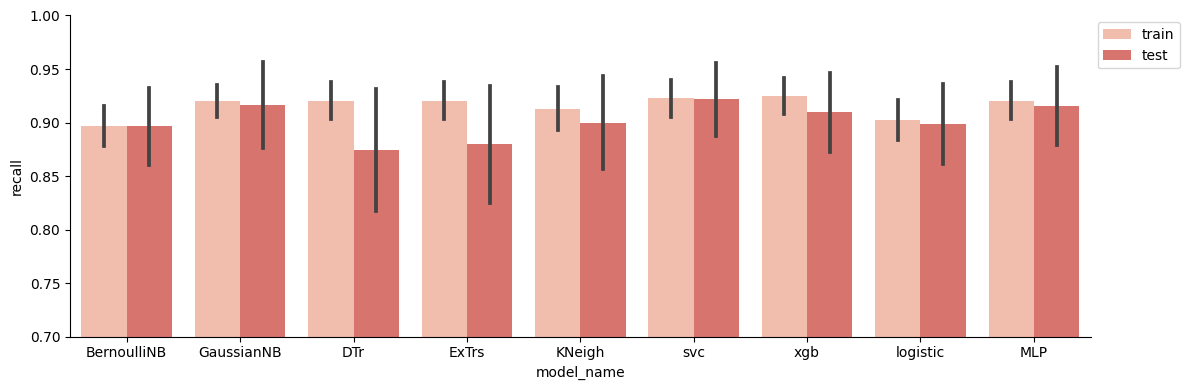

In [9]:
fig, ax = plt.subplots(figsize=(12,4))

sns.barplot(
    data = result_df.filter(['fold_id', 'model_name', 'set'] + ["recall"]),
    x="model_name", y="recall", hue="set",
    palette="Reds", alpha=.75, ax=ax, errorbar='sd'
)

sns.despine(top=True, right=True)

# Set y-axis limits
ax.set_ylim(0.7, 1)

# Move legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()  # Adjust layout so everything fits nicely
plt.savefig('experiment1_recall_NoSys.png', dpi=200 )
plt.show()

Being _SVC_ also a predominant model, let's keep it for the no systolic approach of the prediction as well.

In [10]:
# Saving Result
result_df.to_csv('Data/NoSystolicResultsExperiment1.csv')

# Saving Selected Model

In [11]:
from modeling import train_and_save_model

In [12]:
train_and_save_model('ModelNoSystolic_SVC', models['svc'])